# Building a Convolution Neural Network(CNN)

Known for their capabilities to find patterns in visual data

CNN explainer: https://poloclub.github.io/cnn-explainer/. Check the hyper params in here

We will replicate what is going on there 

In [1]:
import torch as th
import torch.nn as nn

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

import tqdm

## FashionMNIST Dataset 

In [2]:
# Fashion MNIST dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,  # optional transform to be applied to the target
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,  # optional transform to be applied to the target
)

### Plot Sample of images

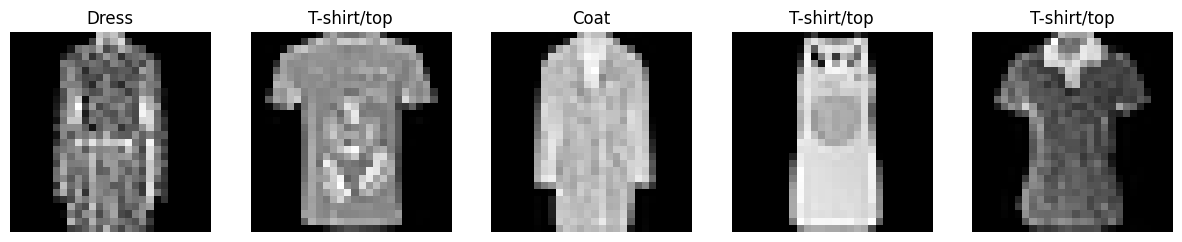

In [3]:
# Plot random 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    idx = np.random.randint(0, len(train_data))
    image, label = train_data[idx]
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(train_data.classes[label])
    axes[i].axis(False)

### Define Constant Batch Size(Samples)

In [4]:
# Data loader
BATCH_SIZE = 32  # meaning 32 images in a batch: 32 images are processed in parallel
train_loader = th.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = th.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_loader), len(test_loader))  # 1875 313

1875 313


## Model Creation

In [5]:
class FashionMNISTModel(nn.Module):
    """
    Model Architecture that replicates the TinyVGG model from CNN explainer.
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        """
        Initialize the model architecture.
        :param input_shape: The shape of the input data.
        :param hidden_units: The number of hidden units in the model.
        :param output_shape: The shape of the output data.
        """
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                7 * 7 * hidden_units, 128
            ),  # 7*7*hidden_units is the size of the image after the convolutions because of the maxpooling layers
            nn.ReLU(),
            nn.Linear(128, output_shape),
        )

        """
        The output of the convolutions block 2
        it goes into the classifier and gets flattened,
        so this line `nn.Linear(7*7*hidden_units, 128)`
        is 7*7*hidden_units, because it is the output shape of the convolutions block 2,
        which is [1, 64, 7, 7] and 7*7*64 = 3136. 64 is the number of hidden units.
        To know the 7*7, we need to know the output shape of the convolutions 
        by using this predefined method: `self._get_conv_output(input_shape)`
        """

    def forward(self, x):
        """
        Forward pass of the model.
        :param x: The input data.
        :return: The output data.

        As an image through layers
        """
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [6]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

## Device Agnostic

In [7]:
# make device agnostic
if th.backends.mps.is_available():
    device = th.device("mps")
    print("MPS device found.")
else:
    device = th.device("cpu")
    print("MPS device not found.")

MPS device found.


### Load Data to device

In [8]:
th.manual_seed(42)
model = FashionMNISTModel(1, 10, len(train_data.classes)).to(device)

In [9]:
th.manual_seed(42)

# Creating batches of images 
images = th.randn(size=(32, 3, 64, 64))
test_images = images[0]

print(f'Images batch shape: {images.shape}')
print(f'Image shape: {test_images.shape}')
print(f'Model Dict: {model.state_dict().keys()}')
print(f'Image Image:\n {test_images}')

Images batch shape: torch.Size([32, 3, 64, 64])
Image shape: torch.Size([3, 64, 64])
Model Dict: odict_keys(['conv_block_1.0.weight', 'conv_block_1.0.bias', 'conv_block_1.2.weight', 'conv_block_1.2.bias', 'conv_block_2.0.weight', 'conv_block_2.0.bias', 'conv_block_2.2.weight', 'conv_block_2.2.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.3.weight', 'classifier.3.bias'])
Image Image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0

## Stepping through `nn.Conv2d`

In [10]:
# Create single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, # Equivalent is the same as color channels
                       out_channels=10, # Equivalent to the number of hidden units(filters)
                       kernel_size=3, # 3 x 3 kernel size.  Equivalent to the size of the filter
                       stride=1, # Equivalent to the step size of the filter
                       padding=1) # Equivalent to the padding of the filter

conv_output = conv_layer(test_images.unsqueeze(0)) # Unsqueeze to add a batch dimension, because conv2d expects a batch dimension
print(f'Conv Output Shape: {conv_output.shape}')

Conv Output Shape: torch.Size([1, 10, 64, 64])


## Stepping through `nn.MaxPool2d()`

In [11]:
print(f'Original Image Shape: {test_images.shape}')
print(f'Unsqueeze Image Shape: {test_images.unsqueeze(0).shape}')

max_pool_layer = nn.MaxPool2d(kernel_size=2) 
"""
if we change to 4, we will have th.Size([1, 10, 16, 16]) 
as it is the max value of the 4x4 grid not the 2x2 grid
"""

print()

# Pass data through just the conv layer
test_image_through_conv = conv_layer(test_images.unsqueeze(0))
print(f'Conv Output Shape: {test_image_through_conv.shape}')

print()

# Pass data through conv layer and max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'Max Pool Output Shape: {test_image_through_conv_and_max_pool.shape}')

Original Image Shape: torch.Size([3, 64, 64])
Unsqueeze Image Shape: torch.Size([1, 3, 64, 64])

Conv Output Shape: torch.Size([1, 10, 64, 64])

Max Pool Output Shape: torch.Size([1, 10, 32, 32])


## Train the model

### Set up loss function and optimizer

In [12]:
# Set up loss function/evaluation metric/optimizer
# from helper_functions import accuracy_fn, train_step, test_step, print_train_time
import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.001)

### Training and Testing

#### Loops Functions

In [13]:
def train_step(
    model: th.nn.Module,
    data_loader: th.utils.data.DataLoader,
    loss_fn: th.nn.Module,
    optimizer: th.optim.Optimizer,
    accuracy_fn,
    device: th.device = device,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(
            y_true=y, y_pred=y_pred.argmax(dim=1)
        )  # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\rTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    data_loader: th.utils.data.DataLoader,
    model: th.nn.Module,
    loss_fn: th.nn.Module,
    accuracy_fn,
    device: th.device = device,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with th.no_grad():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y,
                y_pred=test_pred.argmax(dim=1),  # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"\rTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")


# Print Training Time Function
def print_train_time(
    start: int,
    end: int,
    device: th.device = None,
):
    """Prints the time elapsed during training.
    Args:
        start (int): Start time in seconds.
        end (int): End time in seconds.
        device (th.device): Device used to train the model (default: None).
    """
    total_time = end - start
    print(f"Total time elapsed: {total_time} seconds.")
    return total_time


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = th.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

#### Loops

In [14]:
th.manual_seed(42)

# Measure the time it takes to train the model
from timeit import default_timer as timer
import tqdm

train_time_start_model = timer()

# Train the model
epochs = 5

for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')
    train_step(
        model = model,
        data_loader=train_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        optimizer=optimizer,
        device=device
    )
    test_step(
        model=model,
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    print()

train_time_end_model = timer()

total_train_time_model = print_train_time(train_time_start_model, train_time_end_model,device=device)

Epoch 1
-------------------------------
Train loss: 2.30211 | Train accuracy: 10.00%
Test loss: 2.30082 | Test accuracy: 9.99%

Epoch 2
-------------------------------
Train loss: 2.29807 | Train accuracy: 12.35%
Test loss: 2.29361 | Test accuracy: 20.54%

Epoch 3
-------------------------------
Train loss: 2.28012 | Train accuracy: 26.86%
Test loss: 2.24881 | Test accuracy: 26.36%

Epoch 4
-------------------------------
Train loss: 1.58869 | Train accuracy: 45.39%
Test loss: 0.84586 | Test accuracy: 67.69%

Epoch 5
-------------------------------
Train loss: 0.77578 | Train accuracy: 70.61%
Test loss: 0.74842 | Test accuracy: 71.79%

Total time elapsed: 56.954041542 seconds.


### Eval model

#### Function

In [15]:
th.manual_seed(42)


def eval_model(
    model: th.nn.Module,
    data_loader: th.utils.data.DataLoader,
    loss_fn: th.nn.Module,
    accuracy_fn,
):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with th.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(
                y_true=y, y_pred=y_pred.argmax(dim=1)
            )  # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,  # only works when model was created with a class
        "model_loss": loss.item(),
        "model_acc": acc,
    }

#### Loop

In [16]:
model.to('cpu')
model_results = eval_model(
    model=model,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model.to(device)

model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.7484241127967834,
 'model_acc': 71.78514376996804}

## Evaluate random predictions with best model

In [17]:
import random

# random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), 9):
    test_samples.append(sample)
    test_labels.append(label)

In [18]:
def make_predictions(model: th.nn.Module, data: list, device: th.device):
    pred_probs = []
    model.eval()
    with th.inference_mode():
        for sample in data:
            # Prepare sample
            sample = th.unsqueeze(sample, dim=0).to(
                device
            )  # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = th.softmax(
                pred_logit.squeeze(), dim=0
            )  # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return th.stack(pred_probs)

In [19]:
# Make predictions on the test samples
pred_prob = make_predictions(model=model,
                             data=test_samples,
                             device=device)

# Get the predicted labels
pred_labels = pred_prob.argmax(dim=1)

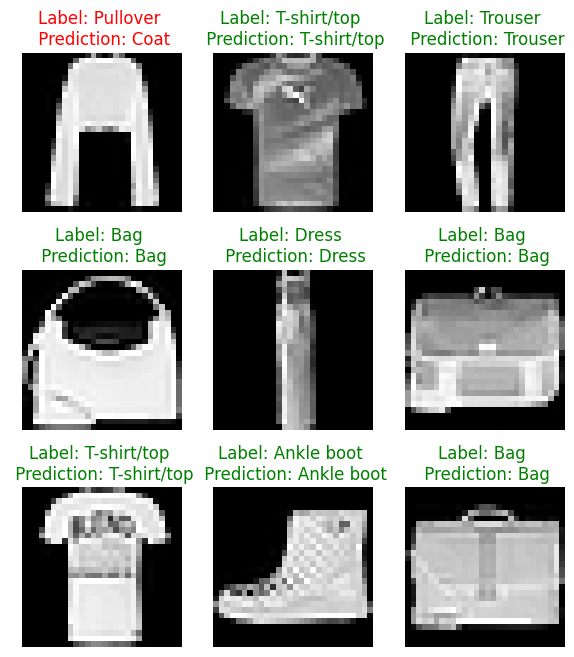

In [20]:
# plot the predictions
plt.figure(figsize=(7, 8))
n_rows, n_cols = 3, 3
for i, (sample, label, pred_label) in enumerate(
    zip(test_samples, test_labels, pred_labels)
):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    if label == pred_label:
        plt.title(
            f"Label: {test_data.classes[label]} \n Prediction: {test_data.classes[pred_label]}",
            color="green",
        )
    else:
        plt.title(
            f"Label: {test_data.classes[label]} \n Prediction: {test_data.classes[pred_label]}",
            color="red",
        )
    plt.axis(False)

plt.show()

## Make a confusion matrix for further prediction evaluation:

1. Make predictions with our trained model on test dataset
2. Make a confusion matrix `torchmatrics.ConfusionMatrix`
3. Plot confusion matrix using `mlxtend.plotting.plot_confusion_matrix`

/Users/yahiaehab/Courses/PyTorch/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 313/313 [00:00<00:00, 365.20it/s]


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

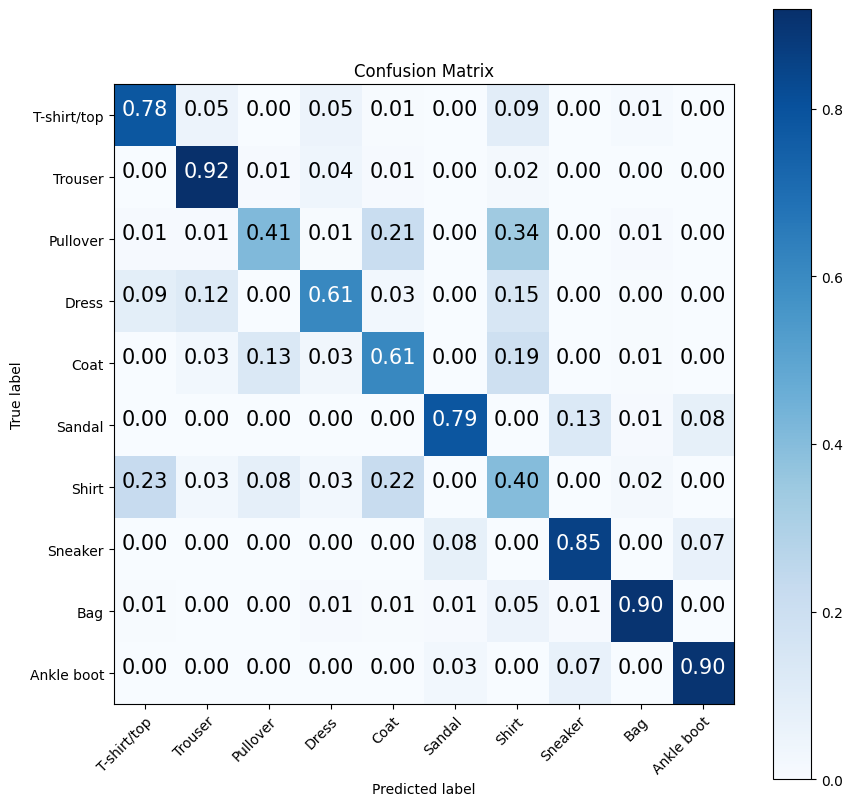

In [21]:
import mlxtend
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with th.inference_mode():
    for X_batch, y_batch in tqdm(test_loader):
        # Send data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Make predictions
        y_pred = model(X_batch)

        # Get predicted class
        y_pred = th.argmax(y_pred, dim=1)

        # Append batch predictions to list
        y_preds.extend(y_pred.cpu().numpy())


# 2. Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_data.targets, y_pred=y_preds)

# 3. Plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues,
                            figsize=(10, 10),
                            savefig=False):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        # Create the figure and axes objects
        fig, ax = plt.subplots(figsize=figsize)
    
        # Create the confusion matrix
        cm = confusion_matrix(y_true=test_data.targets, y_pred=y_preds)
    
        # Normalization option
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
        # Plot the confusion matrix
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
        # Customize the plot
        ax.set(title=title,
             xlabel="Predicted label",
             ylabel="True label",
             xticks=np.arange(len(classes)),
             yticks=np.arange(len(classes)),
             xticklabels=classes,
             yticklabels=classes,
             ylim=[len(classes) - 0.5, -0.5],
             aspect="equal")
    
        # Rotate the xticks
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    
        # Loop through and add the confusion matrix numbers as text annotations
        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2.0  # Used for text coloring below
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                    fontsize=15,
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
        # Add a legend
        fig.colorbar(im)

        return ax

# Define the labels of the class indices (different from the actual class names)
class_names = []

for i in range(10):
     class_names.append(test_data.classes[i])

plot_confusion_matrix(cm=cm, classes=class_names, normalize=True, title="Confusion Matrix", savefig=True)

In [22]:
# 4. Get classification report
from sklearn.metrics import classification_report

# Generate a classification report
class_report = classification_report(y_true=test_data.targets,
                                     y_pred=y_preds)

print(class_report)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1000
           1       0.79      0.92      0.85      1000
           2       0.64      0.41      0.50      1000
           3       0.78      0.61      0.69      1000
           4       0.56      0.61      0.58      1000
           5       0.87      0.79      0.83      1000
           6       0.32      0.40      0.36      1000
           7       0.81      0.85      0.83      1000
           8       0.93      0.90      0.92      1000
           9       0.86      0.90      0.88      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000

